# RL vs LSM Analysis

Concise comparison of a reinforcement learning (RL) swing option pricer versus a Longstaff–Schwartz Monte Carlo (LSM) benchmark for the same monthly contract and HHK process used in the runs. Parameters are summarized in `run.sh` (8192 training paths; evaluation batches of 4096; 22 daily exercise rights; strike 1.0; Q_max 20; OU+jump spot dynamics).

In [ ]:
# 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192, 9216, 10240, 11264, 12288, 13312, 14336, 15360, 16384, 
# 17408, 18432, 19456, 20480, 21504, 22528, 23552, 24576, 25600, 26624, 27648, 28672, 29696, 30720, 31744, 32768

# For Q_max = 5
LSM_path = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_5_16k_14/evaluations/lsm.csv"
RL_path  = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_5_16k_14/evaluations/rl_episode_13312.csv"

# For Q_max = 10
LSM_path = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_10_16k_14/evaluations/lsm.csv"
RL_path  = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_10_16k_14/evaluations/rl_episode_11264.csv"

# For Q_max = 20
LSM_path = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_20_16k_14/evaluations/lsm.csv"
RL_path  = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_20_16k_14/evaluations/rl_episode_14336.csv"

# # For Q_max = 44
# LSM_path = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_44_16k_11/evaluations/lsm.csv"
# RL_path  = "/Users/alexanderithakis/Documents/GitHub/DRL-Swing-Options/logs/SwingOption_44_16k_11/evaluations/rl_episode_13312.csv"

K = 1.0      # strike (from run.sh)
r = 0.05     # risk-free rate (annualized)
maturity = 0.0833  # years (~1 month)
n_rights = 22
DT = maturity / n_rights
Q_MAX = 20.0

In [12]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
sns.set_context('talk'); sns.set_style('whitegrid')

In [13]:
# Load evaluation CSVs
def load_eval_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalize column names
    df.columns = [c.strip() for c in df.columns]
    # Required minimal schema
    cols = set(df.columns)
    payoff_candidates = ['reward', 'Payoff', 'payoff']
    assert any(c in cols for c in payoff_candidates), 'Missing reward/Payoff column'
    assert 'path' in cols and 'time_step' in cols and 'q_t' in cols, 'Missing core columns'
    return df


df_rl = load_eval_csv(RL_path)
df_lsm = load_eval_csv(LSM_path)
# Identify payoff column per file
cands = ['reward', 'Payoff', 'payoff']
pay_col_rl  = next(c for c in cands if c in df_rl.columns)
pay_col_lsm = next(c for c in cands if c in df_lsm.columns)
len(df_rl), len(df_lsm), pay_col_rl, pay_col_lsm

(86737, 90112, 'reward', 'payoff')

In [14]:
# Aggregate to per-path PV and exercised quantity
def add_discounted_payoff(df: pd.DataFrame, pay_col: str) -> pd.DataFrame:
    df = df.copy()
    if pay_col.lower() == 'payoff':
        # Assume payoff is undiscounted flow q_t * (S-K)^+
        df['df'] = np.exp(-r * (df['time_step'] + 1) * DT)
        df['payoff_disc'] = df[pay_col] * df['df']
        df['PV_component'] = df['payoff_disc']
    else:
        # RL 'reward' already discounted by environment
        df['PV_component'] = df[pay_col]
    return df

def per_path_stats(df: pd.DataFrame, pay_col: str) -> pd.DataFrame:
    df2 = add_discounted_payoff(df, pay_col)
    g = df2.groupby('path', as_index=False)
    pv = g['PV_component'].sum().rename(columns={'PV_component': 'PV'})
    qtot = g['q_t'].sum().rename(columns={'q_t': 'Q_total'})
    merges = pv.merge(qtot, on='path', how='inner')
    return merges

pp_rl  = per_path_stats(df_rl, 'reward').assign(method='RL')
pp_lsm = per_path_stats(df_lsm, 'payoff').assign(method='LSM')
pp = pd.concat([pp_rl, pp_lsm], ignore_index=True)

# Get the 100 paths which have the biggest difference in PV between the 2 methods
pp_rl  = per_path_stats(df_rl, 'reward').assign(method='RL')
pp_lsm = per_path_stats(df_lsm, 'payoff').assign(method='LSM')
pp = pd.concat([pp_rl, pp_lsm], ignore_index=True)

# Get the top 50 paths with the biggest absolute difference in PV between the 2 methods
rl_stats = pp_rl[['path', 'PV', 'Q_total']].rename(columns={'PV': 'RL_PV', 'Q_total': 'RL_Q_total'})
lsm_stats = pp_lsm[['path', 'PV', 'Q_total']].rename(columns={'PV': 'LSM_PV', 'Q_total': 'LSM_Q_total'})
merged = rl_stats.merge(lsm_stats, on='path', how='inner')
merged['PV_diff'] = merged['RL_PV'] - merged['LSM_PV']
merged['abs_diff'] = merged['PV_diff'].abs()
top_50 = merged.sort_values('abs_diff', ascending=False).drop(columns=['abs_diff']).set_index('path').reindex(columns=['RL_PV','LSM_PV', 'RL_Q_total', 'LSM_Q_total', 'PV_diff'])

display(top_50.head(15).style.background_gradient(cmap='RdYlGn', subset=['PV_diff']))

,RL_PV,LSM_PV,RL_Q_total,LSM_Q_total,PV_diff
path,,,,,
1716,4.773989,7.648817,20.000000,20.000000,-2.874828
3631,3.419060,6.235502,20.000000,20.000000,-2.816442
2096,6.486634,9.082727,20.000000,20.000000,-2.596093
1832,22.892819,25.101477,20.000000,20.000000,-2.208658
1469,6.321406,8.525922,20.000000,20.000000,-2.204516
460,14.801536,16.777468,20.000000,20.000000,-1.975932
2300,5.783065,7.677719,20.000000,20.000000,-1.894654
465,4.574249,6.384885,19.999999,20.000000,-1.810636
3670,5.051837,6.708317,20.000000,20.000000,-1.656480


In [15]:
# Summary price statistics and 95% CI
from typing import Tuple

def ci95(a: np.ndarray) -> Tuple[float, float, int, float]:
    a = np.asarray(a)
    m = a.mean()
    s = a.std(ddof=1)
    n = len(a)
    se = s/np.sqrt(n) if n > 0 else np.nan
    half = stats.t.ppf(0.975, df=n-1) * se if n > 1 else np.nan
    return m, s, n, half

summ_rows = []
for name, grp in pp.groupby('method'):
    m, s, n, h = ci95(grp['PV'].values)
    mQ, sQ, nQ, hQ = ci95(grp['Q_total'].values)
    summ_rows.append({
        'method': name,
        'PV_mean': m, 'PV_std': s, 'N': n, 'PV_CI95': h,
        'Q_mean': mQ, 'Q_std': sQ, 'Q_CI95': hQ
    })

summary = pd.DataFrame(summ_rows).set_index('method').sort_index()
# Delta metrics (RL vs LSM)
if set(summary.index) >= {'RL','LSM'}:
    m_rl, m_lsm = summary.loc['RL','PV_mean'], summary.loc['LSM','PV_mean']
    delta = m_rl - m_lsm
    rel_err = delta / m_lsm if m_lsm != 0 else np.nan
    results = {'delta_mean': delta, 'rel_error': rel_err}
else:
    results = {}

summary#, results

,PV_mean,PV_std,N,PV_CI95,Q_mean,Q_std,Q_CI95
method,,,,,,,
LSM,2.685314,2.856311,4096,0.087499,11.252441,7.825493,0.239722
RL,2.684009,2.721750,4096,0.083377,11.632615,7.784298,0.238460


### What follows: Price distributions and ECDF
Overlaid KDE and ECDF of per-path present values for RL vs LSM. Vertical lines mark mean and selected quantiles (50%, 90%, 99%) per method to compare central tendency and tail behavior.

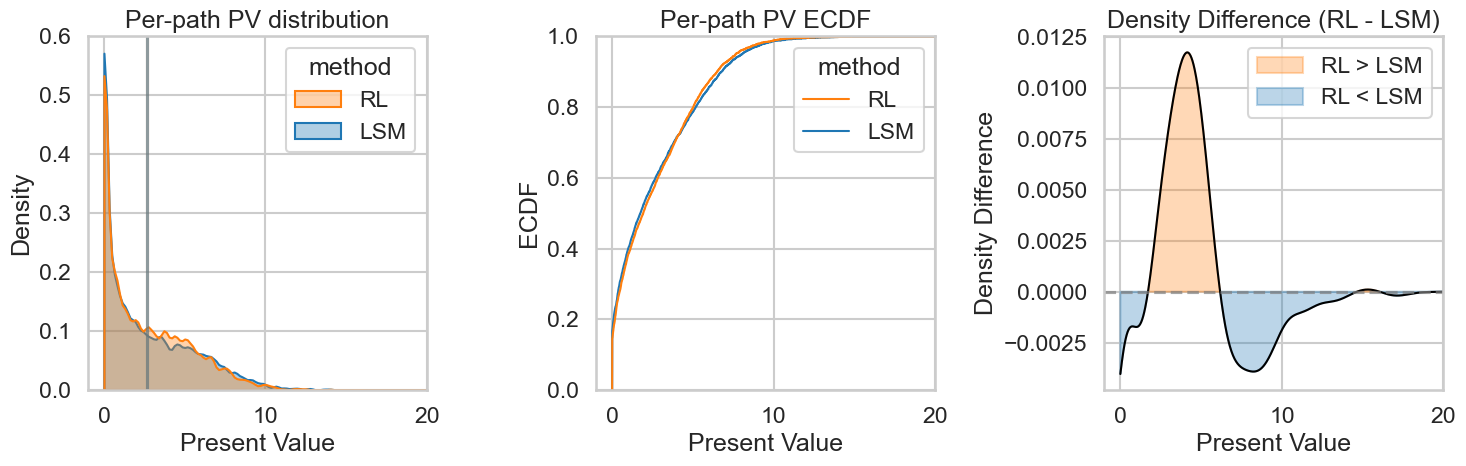

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# KDE plot
sns.kdeplot(data=pp, x='PV', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, fill=True, common_norm=False, alpha=0.35, linewidth=1.5, ax=axes[0], bw_adjust=0.3, clip=(pp['PV'].min(), pp['PV'].max()),)
axes[0].axvline(m_rl, color='tab:orange', ymin=0, ymax=1, alpha=0.5, label=f'RL Mean: {m_rl:.4f}')
axes[0].axvline(m_lsm, color='tab:blue', ymin=0, ymax=1, alpha=0.5, label=f'LSM Mean: {m_lsm:.4f}')
axes[0].set_title('Per-path PV distribution')
axes[0].set_xlabel('Present Value')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-1, 20)

# ECDF plot
sns.ecdfplot(data=pp, x='PV', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, linewidth=1.5, ax=axes[1])
axes[1].set_title('Per-path PV ECDF')
axes[1].set_xlabel('Present Value')
axes[1].set_ylabel('ECDF')
axes[1].set_xlim(-1, 20)

# Density difference plot
rl_pv = pp[pp['method'] == 'RL']['PV'].values
lsm_pv = pp[pp['method'] == 'LSM']['PV'].values

kde_rl = stats.gaussian_kde(rl_pv, bw_method=0.3)  # Match bw_adjust from KDE plot
kde_lsm = stats.gaussian_kde(lsm_pv, bw_method=0.3)

x_grid = np.linspace(pp['PV'].min(), pp['PV'].max(), 1000)
rl_density = kde_rl(x_grid)
lsm_density = kde_lsm(x_grid)
density_diff = rl_density - lsm_density

axes[2].plot(x_grid, density_diff, color='black', linewidth=1.5)
axes[2].axhline(0, color='gray', linestyle='--', alpha=0.7)
axes[2].fill_between(x_grid, density_diff, 0, where=(density_diff > 0), color='tab:orange', alpha=0.3, label='RL > LSM')
axes[2].fill_between(x_grid, density_diff, 0, where=(density_diff < 0), color='tab:blue', alpha=0.3, label='RL < LSM')
axes[2].set_title('Density Difference (RL - LSM)')
axes[2].set_xlabel('Present Value')
axes[2].set_ylabel('Density Difference')
axes[2].set_xlim(-1, 20)
axes[2].legend()

plt.tight_layout()
plt.show()

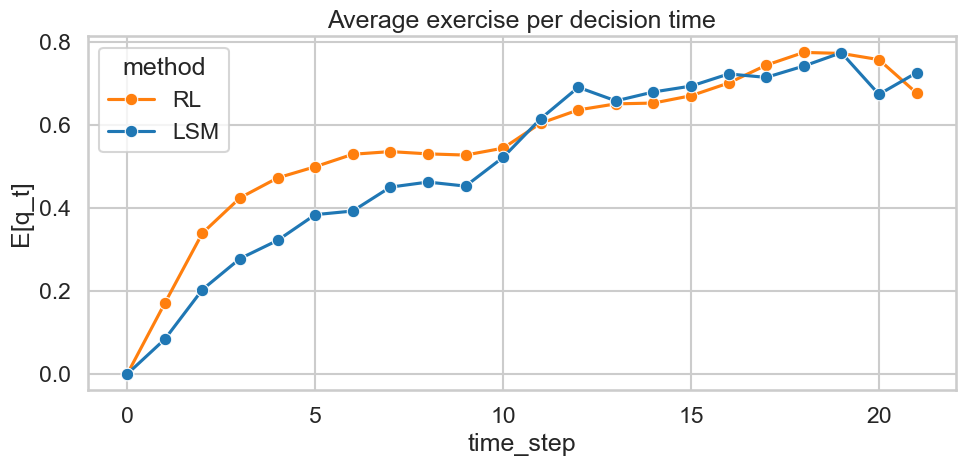

In [17]:
# Average exercise profile over time (mean q_t per time_step)
def avg_profile(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('time_step', as_index=False)['q_t'].mean().rename(columns={'q_t':'q_mean'})
prof_rl  = avg_profile(df_rl).assign(method='RL')
prof_lsm = avg_profile(df_lsm).assign(method='LSM')
prof = pd.concat([prof_rl, prof_lsm], ignore_index=True)
plt.figure(figsize=(10,5))
sns.lineplot(data=prof, x='time_step', y='q_mean', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, marker='o')
plt.title('Average exercise per decision time')
plt.xlabel('time_step')
plt.ylabel('E[q_t]')
plt.tight_layout(); plt.show()

### What follows: Average exercise per decision time
Mean q_t at each time step across paths for both methods, revealing differences in temporal allocation policies (front-loading vs back-loading vs uniform).

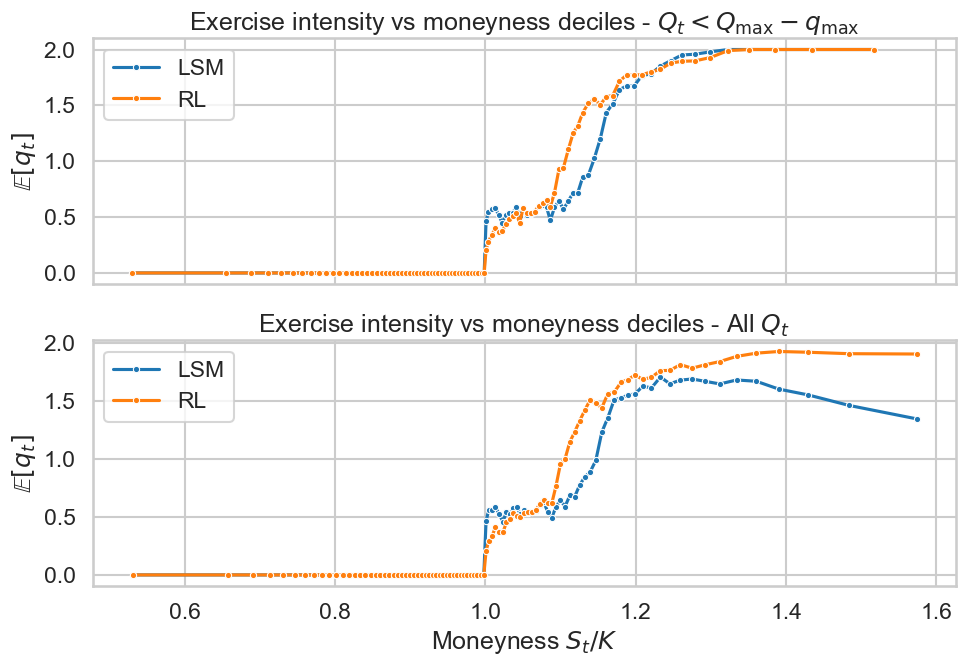

In [18]:
def add_moneyness(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['moneyness'] = df.get('spot', np.nan) / K
    return df

def moneyness_profile(rl_df, lsm_df, qmax_filter=True):
    rl_m = add_moneyness(rl_df)
    lsm_m = add_moneyness(lsm_df)
    rl_m['q_exercised_norm'] = rl_m['q_exercised_norm'] * Q_MAX
    if qmax_filter:
        rl_m = rl_m.query('q_exercised_norm < @Q_MAX - 2')
        lsm_m = lsm_m.query('q_exercised_so_far < @Q_MAX - 2')
    combined = pd.concat([rl_m.assign(method='RL'), lsm_m.assign(method='LSM')], ignore_index=True)
    combined = combined[np.isfinite(combined['moneyness'])]
    combined['mn_decile'] = pd.qcut(combined['moneyness'], q=100, duplicates='drop')
    midpoints = combined['mn_decile'].apply(lambda iv: (iv.left + iv.right)/2 if hasattr(iv, 'left') else np.nan)
    combined['mn_mid'] = midpoints
    mn_prof = combined.groupby(['method','mn_mid'], as_index=False, observed=True)['q_t'].mean()
    # Remove last row per method without using groupby-apply (avoids FutureWarning)
    def drop_last_per_group(df, group_col):
        idx = df.groupby(group_col).tail(1).index
        return df.drop(idx)
    mn_prof = drop_last_per_group(mn_prof, 'method')
    return mn_prof

mn_prof1 = moneyness_profile(df_rl, df_lsm, qmax_filter=True)
mn_prof2 = moneyness_profile(df_rl, df_lsm, qmax_filter=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
sns.lineplot(data=mn_prof1, x='mn_mid', y='q_t', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, marker='.', hue_order=['LSM','RL'], ax=axes[0])
axes[0].set_title(r'Exercise intensity vs moneyness deciles - $Q_t < Q_\mathrm{max} - q_\mathrm{max}$')
axes[0].set_xlabel("")
axes[0].set_ylabel(r'$\mathbb{E}[q_t]$')
axes[0].legend(loc='upper left')

sns.lineplot(data=mn_prof2, x='mn_mid', y='q_t', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, marker='.', hue_order=['LSM','RL'], ax=axes[1])
axes[1].set_title(r'Exercise intensity vs moneyness deciles - All $Q_t$')
axes[1].set_xlabel(r'Moneyness $S_t/K$')
axes[1].set_ylabel(r'$\mathbb{E}[q_t]$')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

### What follows: Exercise intensity vs moneyness
Average q_t within moneyness deciles per method, highlighting responsiveness to in-the-money states and saturation behavior.

**Efficiency_slope** 
What it is:

- In the notebook: slope = cov(Q_total, PV) / var(Q_total). That’s the OLS slope of PV vs Q_total.
- Interpretation: average marginal PV per extra unit of total exercised quantity across paths. Higher slope ⇒ the policy tends to allocate quantity when it’s more valuable (e.g., when S > K), i.e., better “value-per-unit” efficiency.

**Hazard_rate**
What it is:

- In the notebook: h_t = P(first_ex = t | first_ex >= t). The hazard rate at time t is the probability of first exercise at time t, given that it has not occurred before t.

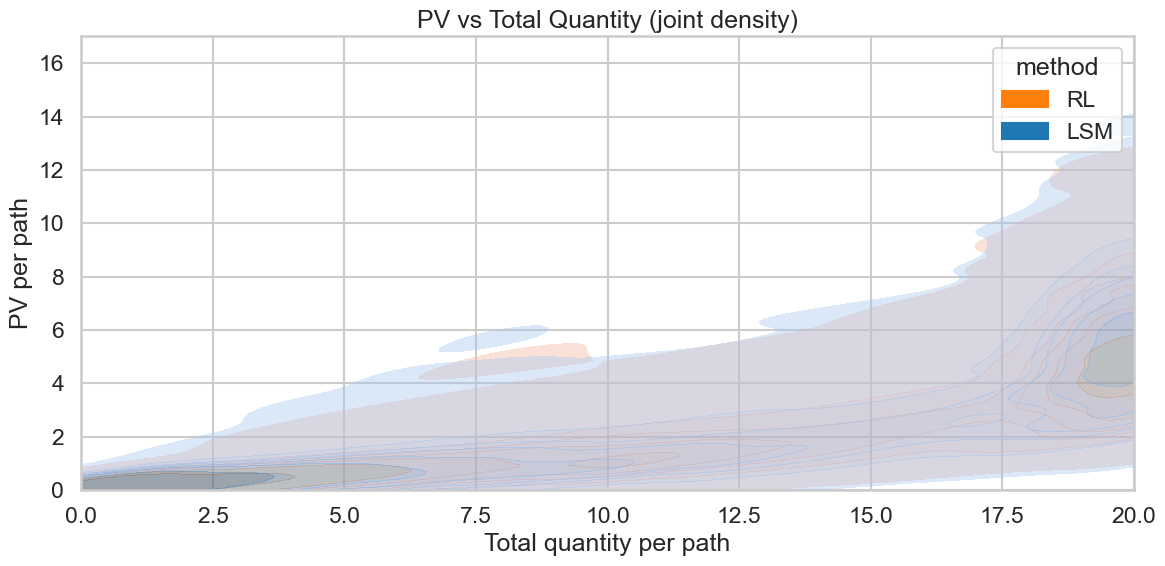

Efficiency slope (PV vs Q_total) per method for spot/K > 1 (bootstrap 95% CI):


,efficiency_slope,CI_5%,CI_95%
method,,,
LSM,0.2935,0.2865,0.3013
RL,0.2840,0.2774,0.2911


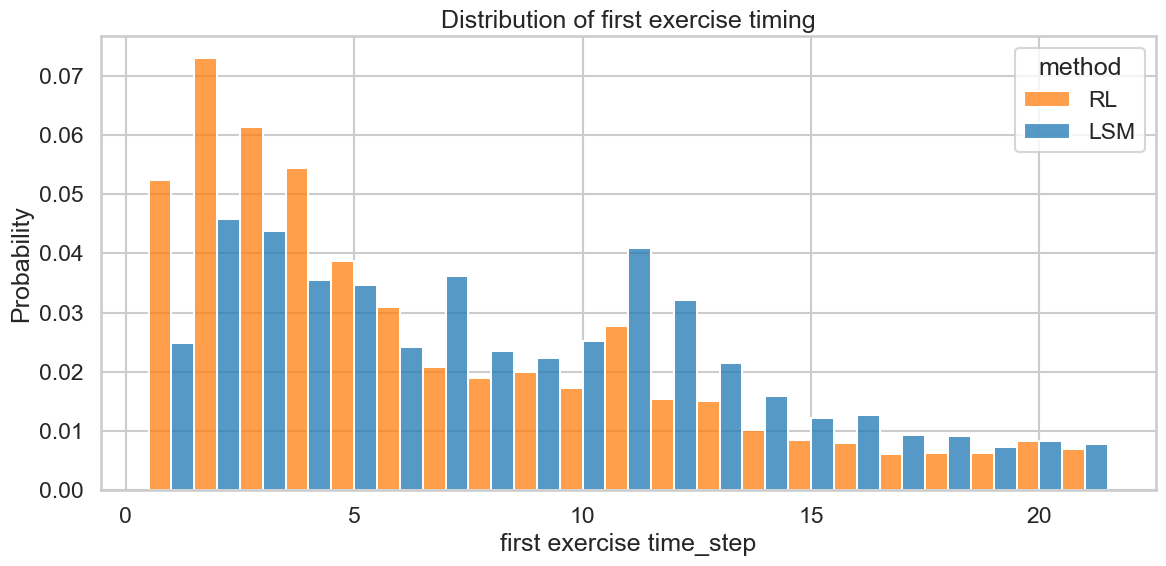

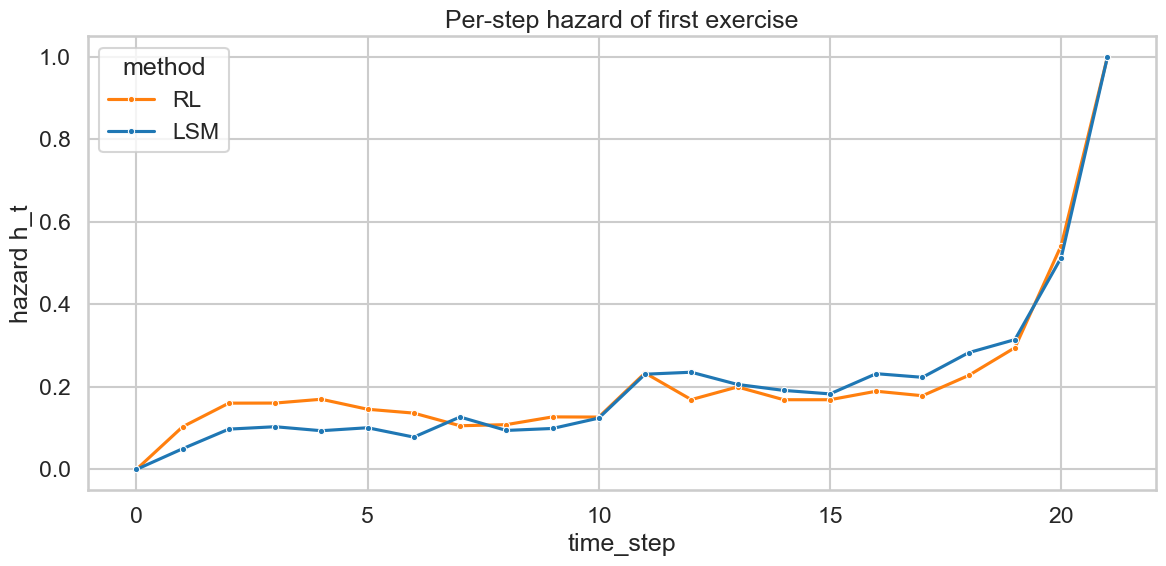

Bootstrap mean delta (RL-LSM PV): -0.003140
95% CI: [-0.124485, 0.112910]

Welch's t-test results:
  PV:      t = -0.0212, p = 0.983
  1st ex:  t = -13.7266, p = 2.51e-42


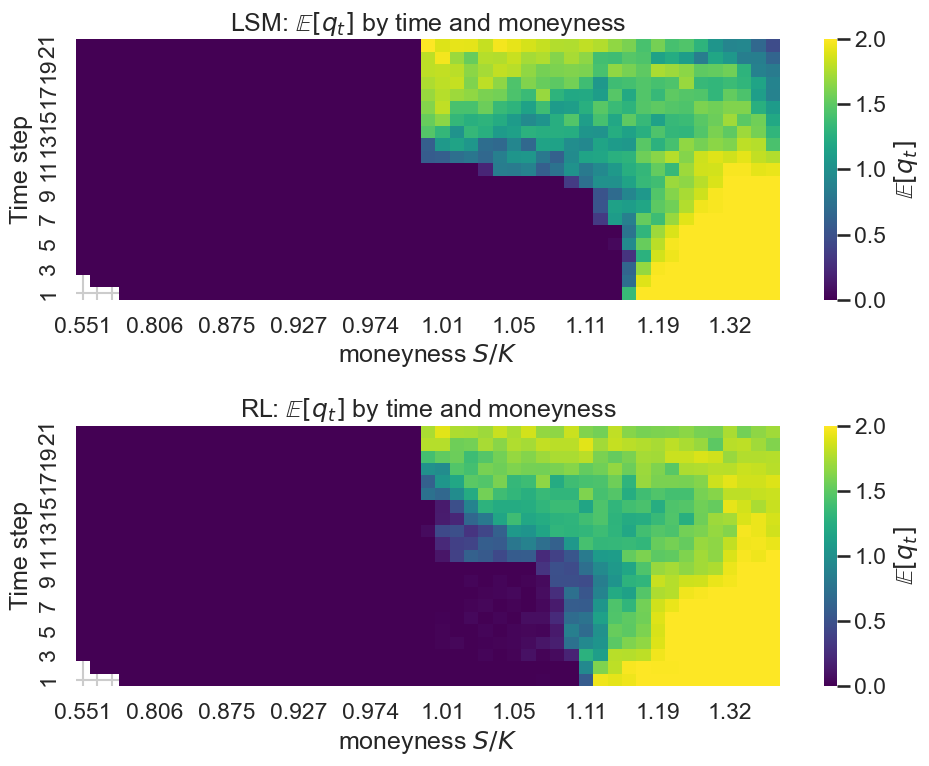

In [19]:
# Additional analyses: quantity allocation, efficiency, timing, significance, state conditioning
from sklearn.utils import resample
from scipy import stats as spstats

# # 1) Cumulative exercise curves (mean over paths)
# def cumulative_profile(df: pd.DataFrame) -> pd.DataFrame:
#     g = df.sort_values(['path','time_step']).copy()
#     g['cum_q'] = g.groupby('path')['q_t'].cumsum()
#     prof = g.groupby('time_step', as_index=False)['cum_q'].mean()
#     prof['cum_q_norm'] = prof['cum_q'] / Q_MAX
#     return prof

# cum_rl  = cumulative_profile(df_rl).assign(method='RL')
# cum_lsm = cumulative_profile(df_lsm).assign(method='LSM')
# cum_all = pd.concat([cum_rl, cum_lsm], ignore_index=True)
# plt.figure(figsize=(12,6))
# sns.lineplot(
#     data=cum_all, x='time_step', y='cum_q_norm', hue='method', marker='.',
#     palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}
# )
# plt.title('Cumulative exercise (mean across paths)')
# plt.xlabel('time_step')
# plt.ylabel(r'$\mathbb{E}[Q_t]\,/\,Q_\mathrm{max}$')
# plt.tight_layout(); plt.show()


# 2) PV vs total quantity: efficiency slope and joint density
plt.figure(figsize=(12,6))
xmin, xmax = pp['Q_total'].quantile([0.0001, 0.999])
ymin, ymax = pp['PV'].quantile([0.0001, 0.999])
sns.kdeplot(
    data=pp,
    x='Q_total', y='PV', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'},
    fill=True,
    common_norm=False,      # don't force equal areas across methods
    common_grid=True,       # evaluate densities on same grid
    bw_adjust=0.6,          # more detail (try 0.4..1.2)
    gridsize=200,           # resolution of grid (100-300)
    thresh=0.01,            # show more tail structure (0.005-0.05)
    levels=8,               # number of contour levels
    alpha=0.4,
    clip=((xmin, xmax), (ymin, ymax))
)
plt.title('PV vs Total Quantity (joint density)')
plt.xlabel('Total quantity per path')
plt.ylabel('PV per path')
plt.tight_layout(); plt.show()

# Efficiency slope (PV vs Q_total) per method, with bootstrap 95% CI, only for spot/K > 1
def bootstrap_efficiency_slope(df, B=2000, seed=42):
    rng = np.random.default_rng(seed)
    x = df['Q_total'].values
    y = df['PV'].values
    n = len(x)
    slopes = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        xb = x[idx]
        yb = y[idx]
        var_x = np.var(xb, ddof=1)
        if var_x > 0:
            slope = np.cov(xb, yb, ddof=1)[0, 1] / var_x
        else:
            slope = np.nan
        slopes.append(slope)
    return np.mean(slopes), np.percentile(slopes, [2.5, 97.5])

eff_rows = []
for name, grp in pp.groupby('method'):
    # Only include paths where spot/K > 1 at any time
    if 'spot' in grp.columns:
        mask = grp['spot'] / K > 1
        grp = grp[mask]
    else:
        # Join with original data to get spot if not present
        if name == 'RL':
            spot_df = df_rl.groupby('path')['spot'].max().reset_index()
        else:
            spot_df = df_lsm.groupby('path')['spot'].max().reset_index()
        merged = grp.merge(spot_df, on='path')
        mask = merged['spot'] / K > 1
        grp = merged[mask]
    mean_slope, (ci_lo, ci_hi) = bootstrap_efficiency_slope(grp)
    eff_rows.append({'method': name, 'efficiency_slope': mean_slope, 'CI_5%': ci_lo, 'CI_95%': ci_hi})
eff_df = pd.DataFrame(eff_rows).set_index('method')
print("Efficiency slope (PV vs Q_total) per method for spot/K > 1 (bootstrap 95% CI):")
display(eff_df.style.format({"efficiency_slope": "{:.4f}", "CI_5%": "{:.4f}", "CI_95%": "{:.4f}"}))


# 3) First-exercise timing distribution and hazard rates
def first_exercise_step(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp['is_ex'] = tmp['q_t'] > 1e-8
    first = tmp[tmp['is_ex']].groupby('path', as_index=False)['time_step'].min()
    first = first.rename(columns={'time_step':'first_ex'})
    first['first_ex'] = first['first_ex'].astype(int)
    return first

f_rl = first_exercise_step(df_rl).assign(method='RL')
f_lsm = first_exercise_step(df_lsm).assign(method='LSM')
f_all = pd.concat([f_rl, f_lsm], ignore_index=True)
plt.figure(figsize=(12,6))
sns.histplot(data=f_all, x='first_ex', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, kde=False, stat='probability', discrete=True, multiple='dodge')
plt.title('Distribution of first exercise timing')
plt.xlabel('first exercise time_step')
plt.ylabel('Probability')
plt.tight_layout(); plt.show()


# Hazard rate h_t = P(first_ex = t | first_ex >= t)
def hazard_from_first_ex(first_df: pd.DataFrame, nT: int) -> pd.DataFrame:
    counts = first_df['first_ex'].value_counts().reindex(range(nT), fill_value=0).astype(float)
    survivors = counts[::-1].cumsum()[::-1]
    denom = survivors.copy()
    denom[denom==0] = np.nan
    hazard = counts / denom
    return pd.DataFrame({'time_step': range(nT), 'hazard': hazard.values})

nT = int(df_rl['time_step'].max()) + 1
hz_rl  = hazard_from_first_ex(f_rl, nT).assign(method='RL')
hz_lsm = hazard_from_first_ex(f_lsm, nT).assign(method='LSM')
hz_all = pd.concat([hz_rl, hz_lsm], ignore_index=True)
plt.figure(figsize=(12,6))
sns.lineplot(data=hz_all, x='time_step', y='hazard', hue='method', palette={'RL': 'tab:orange', 'LSM': 'tab:blue'}, marker='.')
plt.title('Per-step hazard of first exercise')
plt.xlabel('time_step')
plt.ylabel('hazard h_t')
plt.tight_layout(); plt.show()


# 4) Bootstrap CI for mean delta (RL−LSM)
def bootstrap_delta(pp_rl: pd.DataFrame, pp_lsm: pd.DataFrame, B=2000, seed=42):
    rng = np.random.default_rng(seed)
    rl_vals = pp_rl['PV'].values
    lsm_vals = pp_lsm['PV'].values
    deltas = []
    n = min(len(rl_vals), len(lsm_vals))
    for _ in range(B):
        idx_r = rng.integers(0, len(rl_vals), size=n)
        idx_l = rng.integers(0, len(lsm_vals), size=n)
        deltas.append(rl_vals[idx_r].mean() - lsm_vals[idx_l].mean())
    return np.mean(deltas), np.percentile(deltas, [2.5, 97.5])

b_mean, (b_lo, b_hi) = bootstrap_delta(pp_rl, pp_lsm)
print(f"Bootstrap mean delta (RL-LSM PV): {b_mean:.6f}")
print(f"95% CI: [{b_lo:.6f}, {b_hi:.6f}]")


# 5) Welch's t-tests: PV and first-ex timing
pv_t = spstats.ttest_ind(pp_rl['PV'].values, pp_lsm['PV'].values, equal_var=False)
# Align first-ex arrays by inner join on paths (or compare samples as-is)
t_rl = f_rl['first_ex'].values
t_lsm = f_lsm['first_ex'].values
first_ex_t = spstats.ttest_ind(t_rl, t_lsm, equal_var=False)
print("\nWelch's t-test results:")
print(f"  PV:      t = {pv_t.statistic:.4f}, p = {pv_t.pvalue:.3g}")
print(f"  1st ex:  t = {first_ex_t.statistic:.4f}, p = {first_ex_t.pvalue:.3g}")


# 6) State-conditioned exercise heatmaps (mean q_t by time_step and moneyness)
mny_all = pd.concat([df_lsm['spot'], df_rl['spot']], ignore_index=True) / K
cats = pd.qcut(mny_all, q=50, duplicates='drop')              # one set of quantile bins for BOTH plots (50 quantiles)
edges = np.unique(np.r_[cats.cat.categories[0].left, [c.right for c in cats.cat.categories]])
all_bins = pd.IntervalIndex.from_breaks(edges)

def state_heat_ax(df, ax, bins=all_bins, vmax=2.0, xtick_every=5):
    d = df.copy().query('time_step > 0')
    d['mny'] = d['spot'] / K
    d = d[np.isfinite(d['mny']) & np.isfinite(d['q_t'])]  # guard against NaNs
    d['mny_bin'] = pd.cut(d['mny'], bins=bins, include_lowest=True)

    pivot = d.pivot_table(index='time_step', columns='mny_bin',
                          values='q_t', aggfunc='mean', observed=False)
    pivot = pivot.sort_index().reindex(columns=bins)  # consistent columns across LSM/RL

    sns.heatmap(pivot, cmap='viridis', vmin=0.0, vmax=vmax,
                cbar_kws={'label': r'$\mathbb{E}[q_t]$'}, ax=ax)

    ncols = pivot.shape[1]
    positions = np.arange(ncols) + 0.5                  # centers of heatmap cells
    ax.set_xticks(positions)

    mids = [(iv.left + iv.right) / 2.0 for iv in pivot.columns]
    labels = [f"{m:.3g}" if (i % xtick_every == 0) else "" for i, m in enumerate(mids)]
    ax.set_xticklabels(labels, rotation=0)

    ax.set_xlabel(r'moneyness $S/K$')
    ax.set_ylabel('Time step')
    ax.invert_yaxis()

# Create a single 2x1 figure and plot LSM then RL
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
axes[0].set_title(r'LSM: $\mathbb{E}[q_t]$ by time and moneyness')
axes[1].set_title(r'RL: $\mathbb{E}[q_t]$ by time and moneyness')
state_heat_ax(df_lsm, axes[0], bins=all_bins, vmax=2.0, xtick_every=5)
state_heat_ax(df_rl,  axes[1], bins=all_bins, vmax=2.0, xtick_every=5)
fig.tight_layout()
plt.show()

---
# Short Comparison Graphs

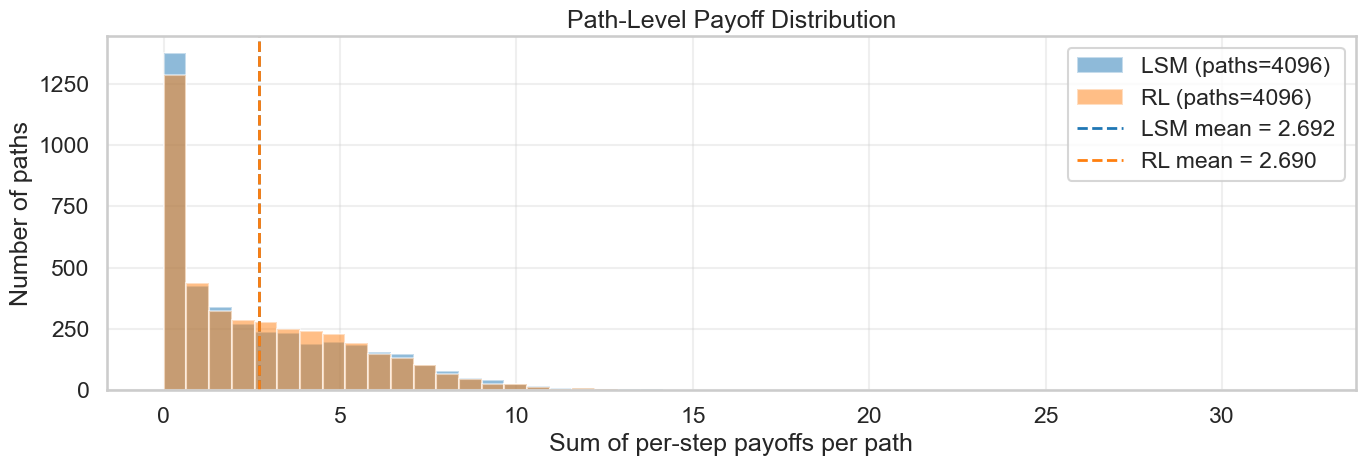

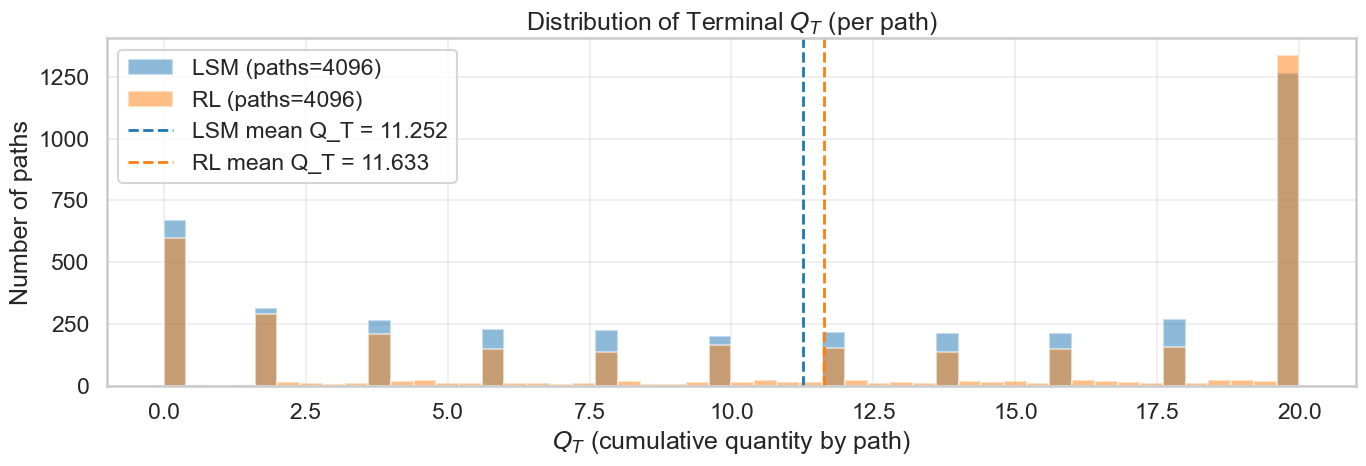

Mean cumulative payoff at T (LSM, from per-path sum): 2.691984
Mean cumulative payoff at T (RL, from per-path sum): 2.690129


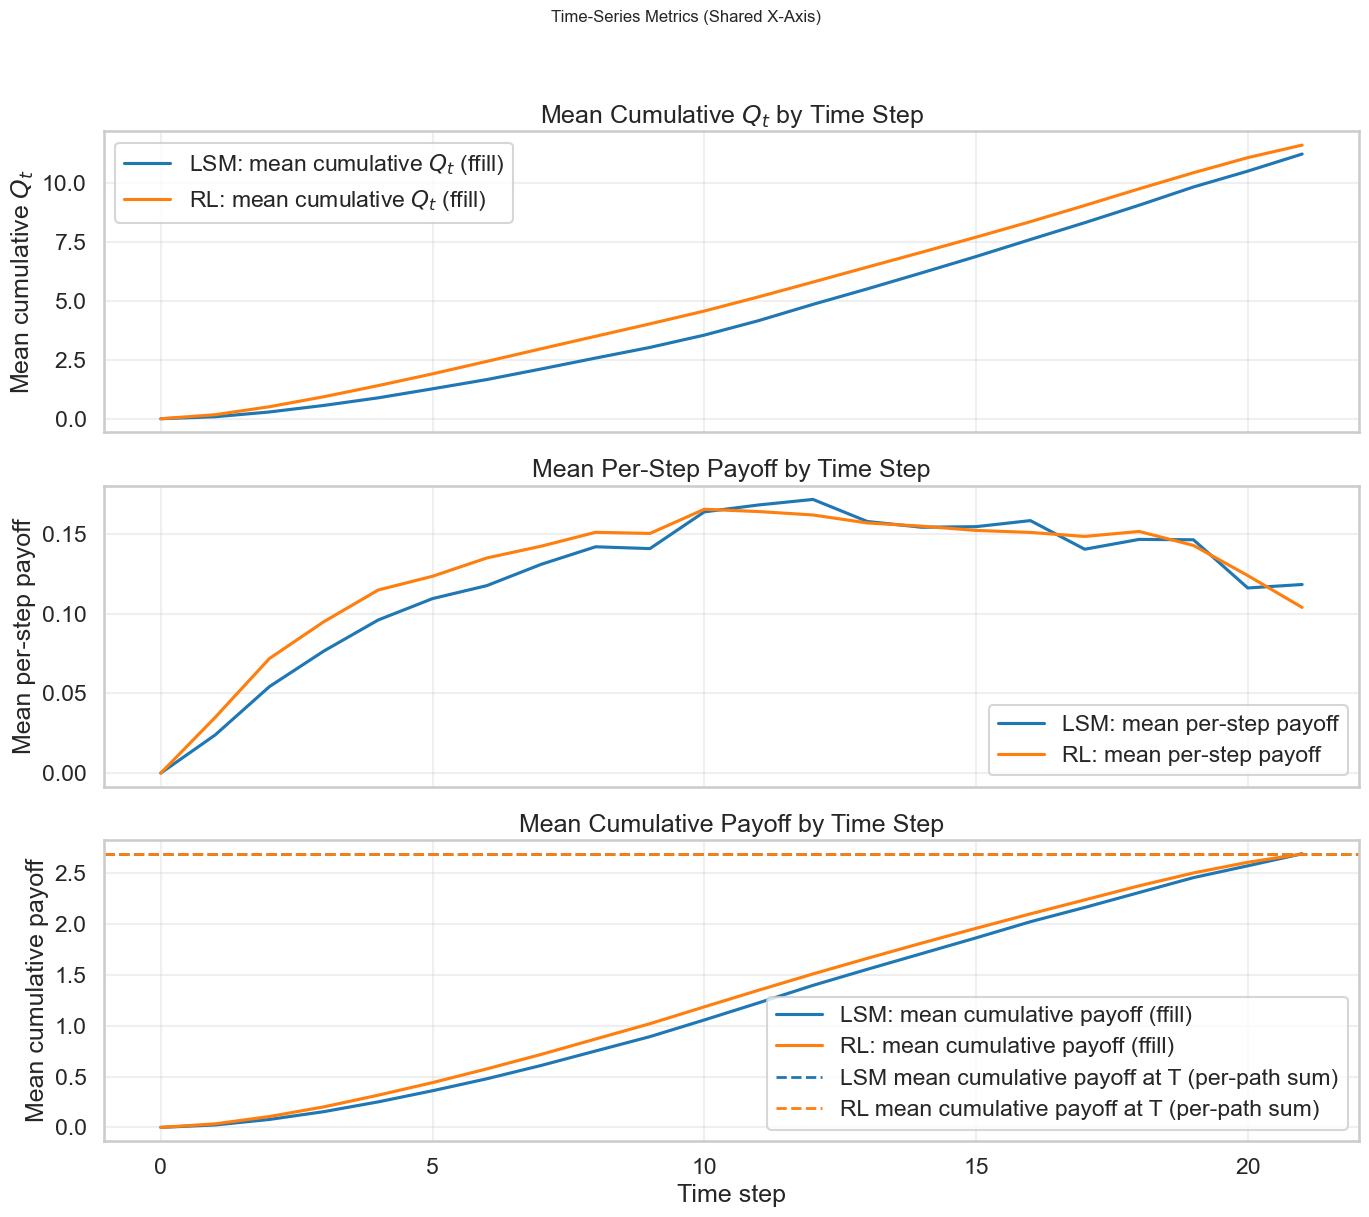

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load & prep
# ----------------------------
lsm = pd.read_csv(LSM_path)
rl  = pd.read_csv(RL_path)

# Running sums by path
lsm['Q_t'] = lsm.groupby('path')['q_t'].cumsum()
rl['Q_t']  = rl.groupby('path')['q_t'].cumsum()

# Per-step payoff (kept your original definition: uses instantaneous q_t)
lsm['payoff'] = np.maximum(lsm['spot'] - 1, 0) * lsm['q_t']
rl['payoff']  = np.maximum(rl['spot'] - 1, 0) * rl['q_t']

lsm.sort_values(['path', 'time_step'], inplace=True)
rl.sort_values(['path', 'time_step'], inplace=True)

# Aggregate to path level (clearer column names)
grouped_lsm = (
    lsm.groupby('path')
       .agg(Q_T=('Q_t','max'), last_time_step=('time_step','max'), path_payoff=('payoff','sum'))
       .reset_index()
    )
grouped_rl = (
    rl.groupby('path')
      .agg(Q_T=('Q_t','max'), last_time_step=('time_step','max'), path_payoff=('payoff','sum'))
      .reset_index()
    )

# Time-step means across paths
lsm['Payoff_t'] = lsm.groupby('path')['payoff'].cumsum()
rl['Payoff_t']  = rl.groupby('path')['payoff'].cumsum()

# --- Forward fill cumulative payoff for each path to ensure all paths contribute their final value at each time step ---
def forward_fill_cum(df, col):
    wide = df.pivot(index='time_step', columns='path', values=col)
    wide_ffill = wide.ffill()
    wide_ffill = wide_ffill.bfill().fillna(0)
    return wide_ffill.mean(axis=1).reset_index(name=f'mean_cum_{col}_ffill')

lsm_cum_payoff_ffill = forward_fill_cum(lsm, 'Payoff_t')
rl_cum_payoff_ffill = forward_fill_cum(rl, 'Payoff_t')
lsm_cum_Q_ffill = forward_fill_cum(lsm, 'Q_t')
rl_cum_Q_ffill = forward_fill_cum(rl, 'Q_t')

grouped_lsm_t = (
    lsm.groupby('time_step')
       .agg(mean_Q_t=('Q_t','mean'), mean_payoff=('payoff','mean'), mean_cum_payoff=('Payoff_t','mean'))
       .reset_index()
    )
grouped_rl_t = (
    rl.groupby('time_step')
      .agg(mean_Q_t=('Q_t','mean'), mean_payoff=('payoff','mean'), mean_cum_payoff=('Payoff_t','mean'))
      .reset_index()
    )

# Common x-range for all time-series plots (acts like sharex)
xmin = int(min(grouped_lsm_t['time_step'].min(), grouped_rl_t['time_step'].min()))
xmax = int(max(grouped_lsm_t['time_step'].max(), grouped_rl_t['time_step'].max()))

# ----------------------------
# 1) Distribution: path-level payoff
# ----------------------------
bins_payoff = np.histogram_bin_edges(
    np.concatenate([grouped_lsm['path_payoff'].values, grouped_rl['path_payoff'].values]),
    bins=50
)

plt.figure(figsize=(14, 5))
plt.hist(grouped_lsm['path_payoff'], bins=bins_payoff, alpha=0.5, label=f'LSM (paths={len(grouped_lsm)})', density=False)
plt.hist(grouped_rl['path_payoff'],  bins=bins_payoff, alpha=0.5, label=f'RL (paths={len(grouped_rl)})',  density=False)

mean_lsm = grouped_lsm['path_payoff'].mean()
mean_rl  = grouped_rl['path_payoff'].mean()
plt.axvline(mean_lsm, linestyle='--', linewidth=2, color='tab:blue', label=f'LSM mean = {mean_lsm:.3f}')
plt.axvline(mean_rl,  linestyle='--', linewidth=2, color='tab:orange', label=f'RL mean = {mean_rl:.3f}')

plt.title('Path-Level Payoff Distribution')
plt.xlabel('Sum of per-step payoffs per path')
plt.ylabel('Number of paths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 2) Distribution: terminal Q_T (per path)
# ----------------------------
bins_q = np.histogram_bin_edges(
    np.concatenate([grouped_lsm['Q_T'].values, grouped_rl['Q_T'].values]),
    bins=50
)

plt.figure(figsize=(14, 5))
plt.hist(grouped_lsm['Q_T'], bins=bins_q, alpha=0.5, label=f'LSM (paths={len(grouped_lsm)})')
plt.hist(grouped_rl['Q_T'],  bins=bins_q, alpha=0.5, label=f'RL (paths={len(grouped_rl)})')

mean_lsm_q = grouped_lsm['Q_T'].mean()
mean_rl_q  = grouped_rl['Q_T'].mean()
plt.axvline(mean_lsm_q, linestyle='--', linewidth=2, color='tab:blue', label=f'LSM mean Q_T = {mean_lsm_q:.3f}')
plt.axvline(mean_rl_q,  linestyle='--', linewidth=2, color='tab:orange', label=f'RL mean Q_T = {mean_rl_q:.3f}')

plt.title('Distribution of Terminal $Q_T$ (per path)')
plt.xlabel(r'$Q_T$ (cumulative quantity by path)')
plt.ylabel('Number of paths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Fix: plot the mean of cumulative payoff at T using per-path sum, to match plot 1 ---
mean_cum_payoff_lsm_T = grouped_lsm['path_payoff'].mean()
mean_cum_payoff_rl_T = grouped_rl['path_payoff'].mean()
print(f"Mean cumulative payoff at T (LSM, from per-path sum): {mean_cum_payoff_lsm_T:.6f}")
print(f"Mean cumulative payoff at T (RL, from per-path sum): {mean_cum_payoff_rl_T:.6f}")

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14, 12))
# --- FIXED: Use forward-filled mean cumulative Q_t for the first plot ---
axs[0].plot(lsm_cum_Q_ffill['time_step'], lsm_cum_Q_ffill['mean_cum_Q_t_ffill'], label='LSM: mean cumulative $Q_t$ (ffill)')
axs[0].plot(rl_cum_Q_ffill['time_step'], rl_cum_Q_ffill['mean_cum_Q_t_ffill'], label='RL: mean cumulative $Q_t$ (ffill)')
axs[0].set_title('Mean Cumulative $Q_t$ by Time Step'); axs[0].set_ylabel('Mean cumulative $Q_t$'); axs[0].legend(); axs[0].grid(True, alpha=0.3)

axs[1].plot(grouped_lsm_t['time_step'], grouped_lsm_t['mean_payoff'], label='LSM: mean per-step payoff')
axs[1].plot(grouped_rl_t['time_step'],  grouped_rl_t['mean_payoff'],  label='RL: mean per-step payoff')
axs[1].set_title('Mean Per-Step Payoff by Time Step'); axs[1].set_ylabel('Mean per-step payoff'); axs[1].legend(); axs[1].grid(True, alpha=0.3)

# --- Use forward-filled mean cumulative payoff for the last plot ---
axs[2].plot(lsm_cum_payoff_ffill['time_step'], lsm_cum_payoff_ffill['mean_cum_Payoff_t_ffill'], label='LSM: mean cumulative payoff (ffill)')
axs[2].plot(rl_cum_payoff_ffill['time_step'], rl_cum_payoff_ffill['mean_cum_Payoff_t_ffill'], label='RL: mean cumulative payoff (ffill)')
axs[2].axhline(mean_cum_payoff_lsm_T, color='tab:blue', linestyle='dashed', linewidth=2, label='LSM mean cumulative payoff at T (per-path sum)')
axs[2].axhline(mean_cum_payoff_rl_T, color='tab:orange', linestyle='dashed', linewidth=2, label='RL mean cumulative payoff at T (per-path sum)')
axs[2].set_title('Mean Cumulative Payoff by Time Step'); axs[2].set_xlabel('Time step'); axs[2].set_ylabel('Mean cumulative payoff')
axs[2].legend(); axs[2].grid(True, alpha=0.3)

fig.suptitle('Time-Series Metrics (Shared X-Axis)', y=1.02, fontsize=12)
fig.tight_layout()
plt.show()
# -------------------------------------------------------------------